In [3]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'
pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
datasets==2.14.1
evaluate==0.4.0
numpy==1.22.4
torch @ https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=a7a49d459bf4862f64f7bc1a68beccf8881c2fa9f3e0569608e16ba6f85ebf7b
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.2%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=26692645ea061a005c57ec581a2d0

In [4]:
from datasets import load_dataset

# clone dataset
# source: https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech
raw_datasets = load_dataset("ucberkeley-dlab/measuring-hate-speech")

print(f"Number of Columns: {raw_datasets['train'].num_columns}")
print(f"Number of Rows: {raw_datasets['train'].num_rows}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Number of Columns: 131
Number of Rows: 135556


In [5]:
# keep only text and specific targets
raw_columns = raw_datasets['train'].column_names
keep_columns = ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability']
remove_columns = set(raw_columns)-set(keep_columns)

preprocessed_datasets = raw_datasets.remove_columns(remove_columns)
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability'],
        num_rows: 135556
    })
})

In [6]:
column_mapping = {column:column.split('_')[1] for column in keep_columns if column.startswith('target')}
print(f"COLUMN_MAPPING: {column_mapping}")

preprocessed_datasets = preprocessed_datasets.rename_columns(column_mapping)
preprocessed_datasets

COLUMN_MAPPING: {'target_race': 'race', 'target_religion': 'religion', 'target_origin': 'origin', 'target_gender': 'gender', 'target_sexuality': 'sexuality', 'target_age': 'age', 'target_disability': 'disability'}


DatasetDict({
    train: Dataset({
        features: ['text', 'race', 'religion', 'origin', 'gender', 'sexuality', 'age', 'disability'],
        num_rows: 135556
    })
})

In [7]:
# get two-way label and label id
ID2LABEL = {}
LABEL2ID = {}

label_id = 0
for label in preprocessed_datasets['train'].features.keys():
    if label in ['text']:
        continue

    ID2LABEL[label_id] = label
    LABEL2ID[label] = label_id

    label_id += 1

print(f"ID2LABEL:\n{ID2LABEL}\n")
print(f"LABEL2ID:\n{LABEL2ID}")

ID2LABEL:
{0: 'race', 1: 'religion', 2: 'origin', 3: 'gender', 4: 'sexuality', 5: 'age', 6: 'disability'}

LABEL2ID:
{'race': 0, 'religion': 1, 'origin': 2, 'gender': 3, 'sexuality': 4, 'age': 5, 'disability': 6}


In [8]:
# get target label counts and percentages
label_counts = {}
label_percentages = {}

for label in LABEL2ID:
    label_counts[label] = sum(preprocessed_datasets['train'][label])
    label_percentages[label] = float(f"{sum(preprocessed_datasets['train'][label]) / len(preprocessed_datasets['train'])*100:.2f}")

print(f"LABEL_COUNTS:\n{label_counts}\n")
print(f"LABEL_PERCENTAGES:\n{label_percentages}")

LABEL_COUNTS:
{'race': 48352, 'religion': 26182, 'origin': 24372, 'gender': 40439, 'sexuality': 22407, 'age': 2005, 'disability': 3716}

LABEL_PERCENTAGES:
{'race': 35.67, 'religion': 19.31, 'origin': 17.98, 'gender': 29.83, 'sexuality': 16.53, 'age': 1.48, 'disability': 2.74}


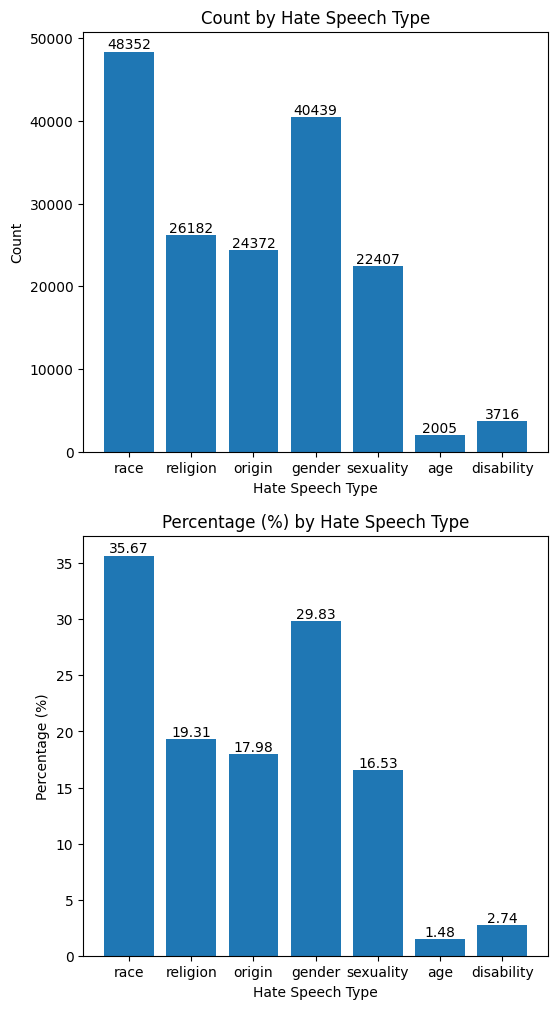

In [9]:
import matplotlib.pyplot as plt

# create 2 graphs
fig, axs = plt.subplots(2, figsize=(6,12))

# create bar graphs of label counts
bar_container0 = axs[0].bar(label_counts.keys(), label_counts.values())
axs[0].bar_label(bar_container0, label_type='edge')
axs[0].set_xlabel('Hate Speech Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Count by Hate Speech Type')

# create bar graphs of label percentages
bar_container1 = axs[1].bar(label_percentages.keys(), label_percentages.values())
axs[1].bar_label(bar_container1, label_type='edge')
axs[1].set_xlabel('Hate Speech Type')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Percentage (%) by Hate Speech Type')

plt.show()

In [10]:
def create_labels(batch):
    # one-hot encode targets for training
    batch['labels'] = [[float(batch[label][i]) for label in LABEL2ID] for i in range(len(batch['text']))]
    return batch

preprocessed_datasets = preprocessed_datasets.map(create_labels, batched=True, remove_columns=LABEL2ID.keys())
preprocessed_datasets

Map:   0%|          | 0/135556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 135556
    })
})

In [11]:
import numpy as np
import torch

# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [12]:
from datasets import DatasetDict

# train (80%), validation (10%), test (10%) split
train_test_datasets = preprocessed_datasets['train'].train_test_split(test_size=0.2, seed=SEED, shuffle=True)
validation_test_datasets = train_test_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

preprocessed_datasets = DatasetDict({
    'train': train_test_datasets['train'],
    'validation': validation_test_datasets['train'],
    'test': validation_test_datasets['test']
})
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
})

In [37]:
from transformers import AutoTokenizer

CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
tokenized_datasets = preprocessed_datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text'])
tokenized_datasets

Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 13556
    })
})

In [14]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# get data collator for data loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# setup dataloaders with tokenized dataset
# to shuffle only be train for each epoch
# in 64 batch sizes with dynamic padding

dataloaders = {}
for dataset_type in tokenized_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=tokenized_datasets[dataset_type],
        batch_size=64,
        shuffle=(dataset_type == 'train'),
        collate_fn=data_collator,
    )

In [15]:
# get current device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    problem_type='multi_label_classification',
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# move model to device
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [17]:
from transformers import AdamW, get_scheduler

# setup optimizer and scheduler
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_epochs = 1
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

print(f"           SCHEDULER NAME: {scheduler_name}")
print(f"                OPTIMIZER: {optimizer.__class__.__name__}")
print(f"NUMBER OF TRAINING EPOCHS: {num_training_epochs}")
print(f" NUMBER OF TRAINING STEPS: {num_training_steps}")

           SCHEDULER NAME: linear
                OPTIMIZER: AdamW
NUMBER OF TRAINING EPOCHS: 1
 NUMBER OF TRAINING STEPS: 1695


In [38]:
from sklearn.metrics import accuracy_score, f1_score

def samples_accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = torch.nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.50).int().numpy()
    samples_accuracy = samples_accuracy_score(labels, predictions)
    samples_f1 = f1_score(labels, predictions, average='samples', zero_division=0)
    return {
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

In [19]:
def train(model, dataloader):
    # setup train metrics
    loss = 0
    train_predictions = []
    train_labels = []

    # set to train mode
    model.train()
    # iterate through dataloader
    for batch in tqdm(dataloader):
        # zero the gradients
        optimizer.zero_grad()

        # predict batch in current device
        batch.to(device)
        outputs = model(**batch)

        # compute multilabel outputs
        predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
        predictions = (predictions >= 0.50).int().numpy()
        labels = batch['labels']

        # backprop and update learning rate
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # accumulate train metrics
        loss += outputs.loss.item()
        train_predictions += predictions.tolist()
        train_labels += labels.tolist()

    # compute train metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(train_labels), np.array(train_predictions))
    samples_f1 = f1_score(np.array(train_labels), np.array(train_predictions), average='samples', zero_division=0)

    # Save the model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, "/content/drive/MyDrive/Colab Notebooks/desktop_data/my_model.pt")

    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }


In [20]:
def evaluate(model, dataloader):
    # setup evaluation metrics variables
    running_loss = 0
    num_samples = 0
    total_accuracy = 0
    total_f1 = 0

    # set to evaluation mode
    model.eval()
    with torch.no_grad():
        # iterate through dataloader
        for batch in tqdm(dataloader):
            # predict batch in current device
            batch = batch.to(device)
            outputs = model(**batch)

            # compute multilabel outputs
            predictions = torch.nn.functional.sigmoid(outputs.logits)
            predictions = (predictions >= 0.50).cpu().numpy()
            labels = batch['labels'].cpu().numpy()

            # accumulate evaluation metrics
            running_loss += outputs.loss.item() * labels.shape[0]
            num_samples += labels.shape[0]
            total_accuracy += samples_accuracy_score(labels, predictions) * labels.shape[0]
            total_f1 += f1_score(labels, predictions, average='samples', zero_division=0) * labels.shape[0]

    # compute evaluation metrics
    final_loss = running_loss / num_samples
    final_accuracy = total_accuracy / num_samples
    final_f1 = total_f1 / num_samples
    return {
        'loss': final_loss,
        'accuracy': final_accuracy,
        'f1': final_f1,
    }


In [21]:
# @title
import os
from transformers import DistilBertForSequenceClassification
from tqdm import tqdm
import torch


if __name__ == "__main__":
  # Define the path to save your model
  save_path = "/content/drive/MyDrive/Colab Notebooks/desktop_data/my_model.pt"  # Replace with your actual save path

  label_dict = {
      'race': 0,
      'religion': 1,
      'origin': 2,
      'gender': 3,
      'sexuality': 4,
      'age': 5,
      'disability': 6
      }
  # Define the model
  model = DistilBertForSequenceClassification.from_pretrained(
      'distilbert-base-uncased',
      num_labels=len(label_dict),
      output_attentions=False,
      output_hidden_states=False
  )

  # Ensure we're using the GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Load the model from a checkpoint if it exists
  if os.path.exists(save_path):
      model.load_state_dict(torch.load(save_path))
      print("Loaded model from checkpoint.")
  else:
      print("No checkpoint found. Starting from scratch.")

  # Continue training from where you left off
  for epoch in range(num_training_epochs):
      train_metrics = train(model, dataloaders['train'])
      validation_metrics = evaluate(model, dataloaders['validation'])

      print(f"EPOCH {epoch+1}", end=" | ")
      print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
      print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" | ")
      print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.5f}", end=" | ")
      print(f"VALIDATION F1: {validation_metrics['f1']:.5f}")

      # Save the model after each epoch
      torch.save(model.state_dict(), save_path)
      print(f"Saved model checkpoint to {save_path} at end of epoch {epoch+1}.")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

No checkpoint found. Starting from scratch.


  0%|          | 5/1695 [00:06<36:52,  1.31s/it]


KeyboardInterrupt: ignored

In [47]:
from transformers import pipeline

# setup pipeline as a text classification with multilabel outputs
hate_speech_multilabel_classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer=tokenizer,
    device=torch.cuda.current_device(),
    top_k=None
)

# Define the label dictionary
label_dict = {
    'race': 0,
    'religion': 1,
    'origin': 2,
    'gender': 3,
    'sexuality': 4,
    'age': 5,
    'disability': 6
}

# Create the reverse dictionary
id2label = {v: k for k, v in label_dict.items()}

def hate_speech_multilabel_classifier(text):
    # Get predictions
    results = pipeline(
        task='text-classification',
        model=model,
        tokenizer=tokenizer,
        device=torch.cuda.current_device(),
        top_k=None
    )(text)

    # Convert labels back to their descriptive form
    for result in results:
        for res in result:
            label_id = int(res['label'].split('_')[1])  # Extract id from 'LABEL_#'
            res['label'] = id2label[label_id]  # Replace 'LABEL_#' with original label

    return results

# Now you can use the function to classify text
print(hate_speech_multilabel_classifier(race_hate_text))

[[{'label': 'race', 'score': 0.48737698793411255}, {'label': 'origin', 'score': 0.24567623436450958}, {'label': 'gender', 'score': 0.08657626062631607}, {'label': 'sexuality', 'score': 0.06803816556930542}, {'label': 'disability', 'score': 0.04446195065975189}, {'label': 'age', 'score': 0.037050168961286545}, {'label': 'religion', 'score': 0.030820194631814957}]]


In [42]:
race_hate_text = """
Yellow peril.
"""

hate_speech_multilabel_classifier(race_hate_text)

[[{'label': 'race', 'score': 0.9932771325111389},
  {'label': 'origin', 'score': 0.0027927232440561056},
  {'label': 'gender', 'score': 0.0021032479126006365},
  {'label': 'disability', 'score': 0.0006467023631557822},
  {'label': 'age', 'score': 0.00047110693412832916},
  {'label': 'sexuality', 'score': 0.0004258415137883276},
  {'label': 'religion', 'score': 0.0002831013407558203}]]

In [43]:
religion_hate_text = """
Nietzsche said 'God is dead'.
"""

hate_speech_multilabel_classifier(religion_hate_text)

[[{'label': 'religion', 'score': 0.9943079352378845},
  {'label': 'race', 'score': 0.0018835286609828472},
  {'label': 'origin', 'score': 0.0014446653658524156},
  {'label': 'gender', 'score': 0.0009952839463949203},
  {'label': 'sexuality', 'score': 0.0007317854324355721},
  {'label': 'disability', 'score': 0.00041232016519643366},
  {'label': 'age', 'score': 0.0002244161005364731}]]

In [44]:
disability_hate_text = """
jihad
"""
hate_speech_multilabel_classifier(disability_hate_text)

[[{'label': 'religion', 'score': 0.9560256600379944},
  {'label': 'race', 'score': 0.028952931985259056},
  {'label': 'origin', 'score': 0.013563264161348343},
  {'label': 'gender', 'score': 0.0007873038412071764},
  {'label': 'sexuality', 'score': 0.00029676611302420497},
  {'label': 'age', 'score': 0.0002132728841388598},
  {'label': 'disability', 'score': 0.00016090148710645735}]]

In [45]:
age_hate_text = """
Old fart.
"""

hate_speech_multilabel_classifier(age_hate_text)

[[{'label': 'age', 'score': 0.6233978867530823},
  {'label': 'gender', 'score': 0.22304843366146088},
  {'label': 'disability', 'score': 0.05784847214818001},
  {'label': 'sexuality', 'score': 0.056156791746616364},
  {'label': 'religion', 'score': 0.016163982450962067},
  {'label': 'race', 'score': 0.015844667330384254},
  {'label': 'origin', 'score': 0.007539798971265554}]]

In [46]:
race_hate_text = """
Snowflake
"""

hate_speech_multilabel_classifier(race_hate_text)

[[{'label': 'race', 'score': 0.48737698793411255},
  {'label': 'origin', 'score': 0.24567623436450958},
  {'label': 'gender', 'score': 0.08657626062631607},
  {'label': 'sexuality', 'score': 0.06803816556930542},
  {'label': 'disability', 'score': 0.04446195065975189},
  {'label': 'age', 'score': 0.037050168961286545},
  {'label': 'religion', 'score': 0.030820194631814957}]]

In [ ]:
#save model: torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/desktop_data/my_model.pt")


In [40]:
#load after mounting drive and access training model!

from transformers import DistilBertForSequenceClassification

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_dict),  # Make sure this is the same as when you saved the model
    output_attentions=False,
    output_hidden_states=False
)

# Load the saved model parameters
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/desktop_data/my_model.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

<All keys matched successfully>

In [48]:
#test metrics after loading saved model
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

100%|██████████| 212/212 [00:50<00:00,  4.19it/s]

TEST ACCURACY: 0.93774 | TEST F1: 0.83098
